### Get EOFs and PCs from SSH barotropic run

Following the example in https://ajdawson.github.io/eofs/latest/api/eofs.standard.html

Using the package `eofs` by Andrew Dawson. 

Cite as:

Dawson, A. (2016). eofs: A library for EOF analysis of meteorological, oceanographic, and climate data. Journal of Open Research Software, 4(1).

In [25]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import MITgcmutils as mit
import numpy as np
import seaborn as sns
from eofs.standard import Eof
from eofs.examples import example_data_path

import sys
sys.path.append('/Users/Karina/Research/SVB/notebooks_SVB/')
import svb_tools as svb
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Read data and bathy
outdir = '/Volumes/KYUUBI/SVB/05_448x512x100/04_feb_TSref/mnc_test_0001/'
bat = mit.mnc.mnc_files(outdir+'grid.t*.nc', layout='exch2')
depth = bat.variables['Depth'][:]
lats = bat.variables['YC'][:,0]
lons = bat.variables['XC'][0,:]-360
hFacC = bat.variables['HFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
bat.close()

eta = mit.mnc.mnc_files(outdir+'eta.0000000000.t*.nc', layout='exch2')
ssh = eta.variables['ETAN'][:]
eta.close()

In [27]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lats))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(ssh, weights=wgts) # I tried with weights=None and I got the same result. KRM

In [29]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof = solver.eofs(neofs=3,eofscaling=1)
eofCorr = solver.eofsAsCorrelation(neofs=3)
pc = solver.pcs(npcs=3, pcscaling=1)
varFact = solver.varianceFraction(neigs=3)

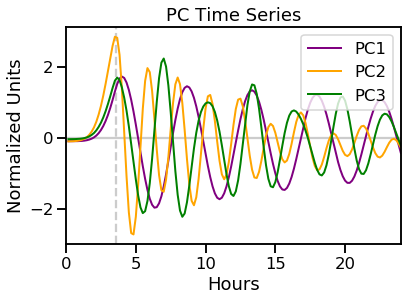

In [30]:
# Plot the leading PC time series.
sns.set_context('talk')
eta = mit.mnc.mnc_files(outdir+'eta.0000000000.t*.nc', layout='exch2')
time = eta.variables['T'][:]
eta.close()

plt.figure()
plt.axhline(0, color='0.8')
plt.axvline(3.6, color='0.8', linestyle='--')
plt.plot(time/3600, pc[:,0], color='purple', linewidth=2, label='PC1')
plt.plot(time/3600, pc[:,1], color='orange', linewidth=2, label='PC2')
plt.plot(time/3600, pc[:,2], color='green', linewidth=2, label='PC3')
plt.title('PC Time Series')
plt.xlabel('Hours')
plt.ylabel('Normalized Units')
plt.xlim(0,24)
#plt.ylim(-3, 3)
plt.legend()
plt.show()

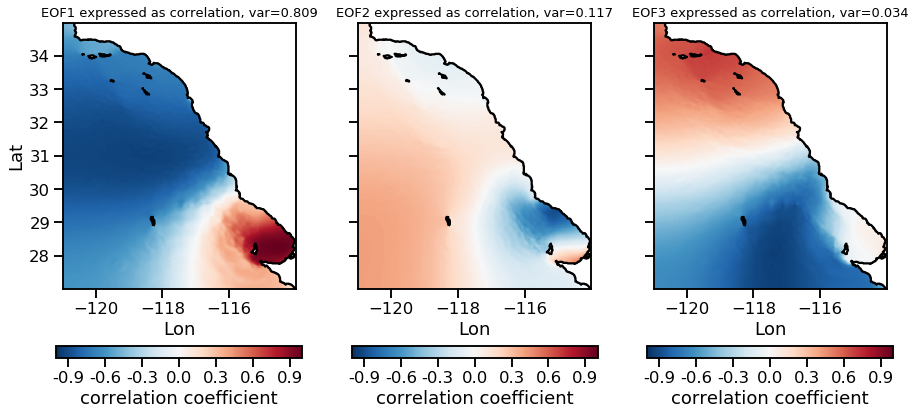

In [31]:
# Plof EOFs expressed as correlation between de PC time series and the time series 
# of the EOF input dataset at each gridpoint. Not related to EOFs computed from the correlation matrix.
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,7), sharey=True)
ax1.set_ylabel('Lat')
for nmode, ax in zip([0,1,2], [ax1,ax2,ax3]):
    cn = ax.pcolormesh(lons, lats, eofCorr[nmode].squeeze(),cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
    cb = plt.colorbar(cn, ax=ax, orientation='horizontal', 
                      format='%1.1f', pad=0.15, ticks=[-0.9,-0.6,-0.3,0,0.3,0.6,0.9])
    cb.set_label('correlation coefficient')
    ax.contour(lons,lats, depth, levels=[0], colors='k')
    ax.set_title('EOF%d expressed as correlation, var=%1.3f' %(nmode+1,varFact[nmode]), fontsize=13)
    ax.set_aspect(1)
    ax.set_xlabel('Lon')

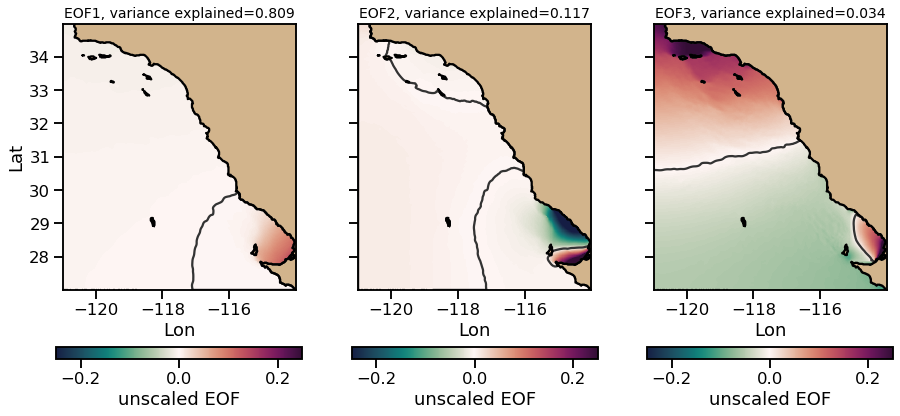

In [39]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,7), sharey=True)
ax1.set_ylabel('Lat')
for nmode, ax in zip([0,1,2], [ax1,ax2,ax3]):
    ax.set_facecolor('tan')
    cn = ax.pcolormesh(lons, lats, np.ma.masked_array(eof[nmode].squeeze(),mask=mask[0,:,:]), 
                       cmap=cmo.cm.curl, vmin=-0.25, vmax=0.25)
    cb = plt.colorbar(cn, ax=ax, orientation='horizontal', pad=0.15)
    ax.contour(lons, lats, eof[nmode].squeeze(), levels=[0],colors=['0.2'])
    ax.contour(lons,lats, depth, levels=[0], colors='k')
    cb.set_label('unscaled EOF')
    ax.set_title('EOF%d, variance explained=%1.3f' %(nmode+1,varFact[nmode]), fontsize=14)
    ax.set_aspect(1)
    ax.set_xlabel('Lon')

### Reconstruct ssh field using each mode (animations)

In [8]:
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

In [22]:
def animate(tt,ax1,ax2,ax3,recon1,recon2,recon3,anim=True):
    cn = ax1.pcolormesh(lons, lats, np.ma.masked_array(recon1[tt,...].squeeze()*100,mask=mask[0,:,:]), 
                       cmap=cmo.cm.curl, vmin=-0.3, vmax=0.3)
    ax1.contour(lons, lats, recon1[tt,...].squeeze()*100, levels=[0],colors=['0.2'])
    ax1.contour(lons,lats, depth, levels=[0], colors='k')
    
    cn = ax2.pcolormesh(lons, lats, np.ma.masked_array(recon2[tt,...].squeeze()*100,mask=mask[0,:,:]), 
                       cmap=cmo.cm.curl, vmin=-0.3, vmax=0.3)
    ax2.contour(lons, lats, recon2[tt,...].squeeze()*100, levels=[0],colors=['0.2'])
    ax2.contour(lons,lats, depth, levels=[0], colors='k')
    
    cn = ax3.pcolormesh(lons, lats, np.ma.masked_array(recon3[tt,...].squeeze()*100,mask=mask[0,:,:]), 
                       cmap=cmo.cm.curl, vmin=-0.3, vmax=0.3)
    ax3.contour(lons, lats, recon3[tt,...].squeeze()*100, levels=[0],colors=['0.2'])
    ax3.contour(lons,lats, depth, levels=[0], colors='k')
    
    if anim==True:
        if tt == 0:
            norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
            cbar_ax = fig.add_axes([0.26, 0.1, 0.5, 0.02])
            cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmo.cm.curl),
                              cax=cbar_ax, orientation='horizontal',label='Free surface (cm)')
    else:
        norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
        cbar_ax = fig.add_axes([0.26, 0.1, 0.5, 0.02])
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmo.cm.curl),
                      cax=cbar_ax, orientation='horizontal',label='Free surface (cm)')
    #if tt == 0:
    #    cb = plt.colorbar(cn, ax=ax, orientation='horizontal', pad=0.15)
    #    cb.set_label('Free surface (cm)')
    ax1.set_title('EOF1 %1.1f hrs, var explained=%1.3f' %(time[tt]/3600,varFact[0]))
    ax2.set_title('EOF2 %1.1f hrs, var explained=%1.3f' %(time[tt]/3600,varFact[1]))
    ax3.set_title('EOF3 %1.1f hrs, var explained=%1.3f' %(time[tt]/3600,varFact[2]))

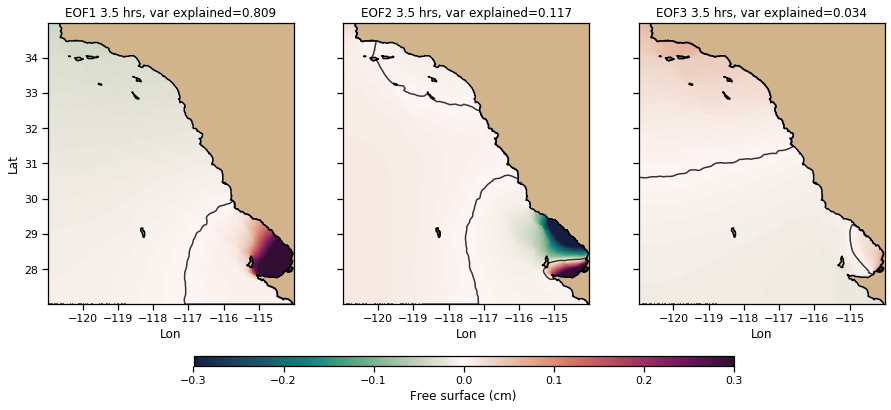

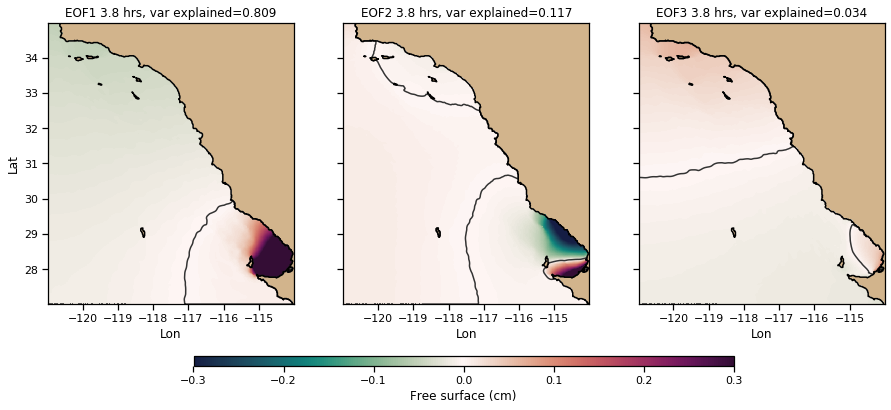

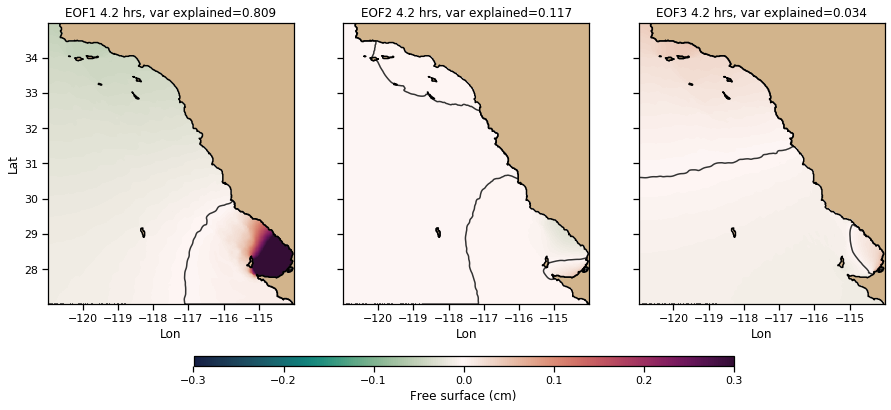

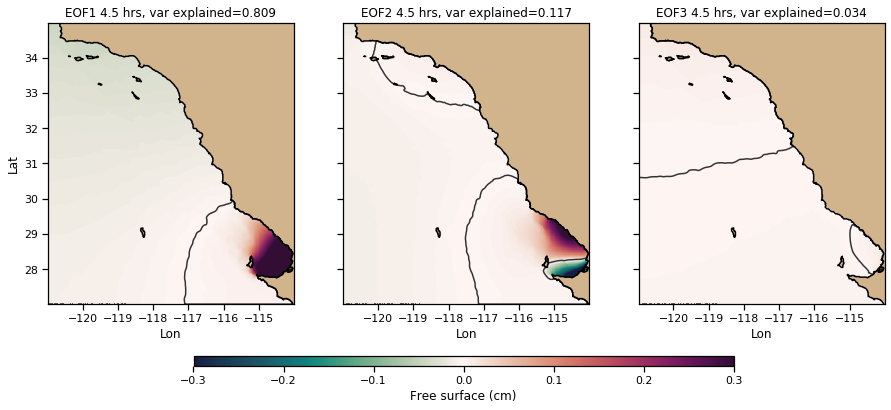

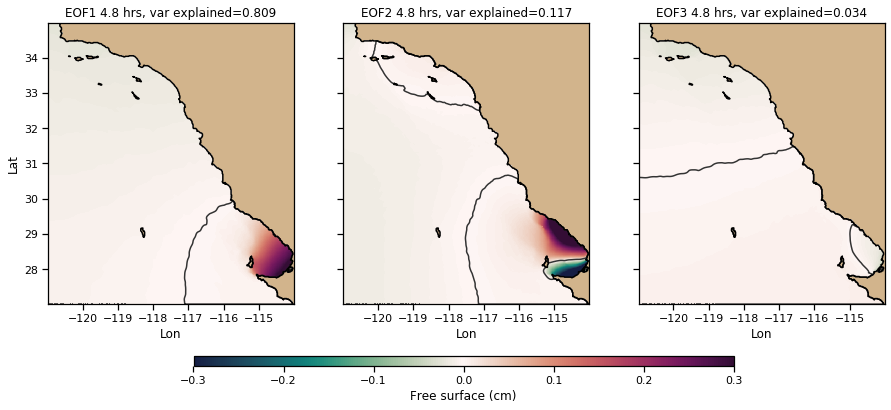

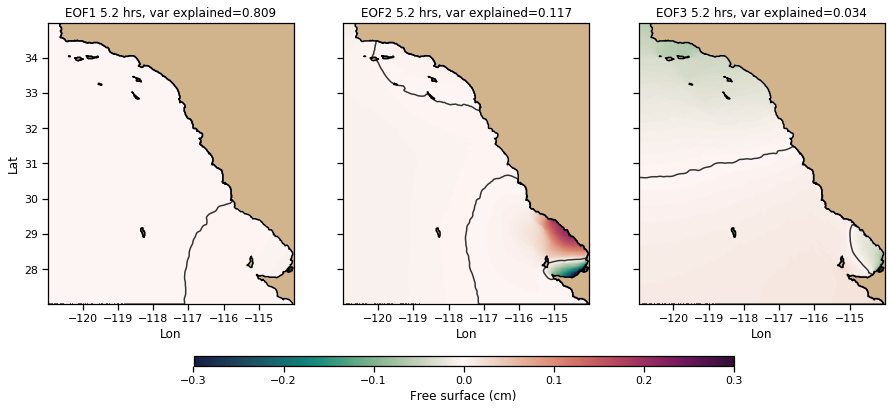

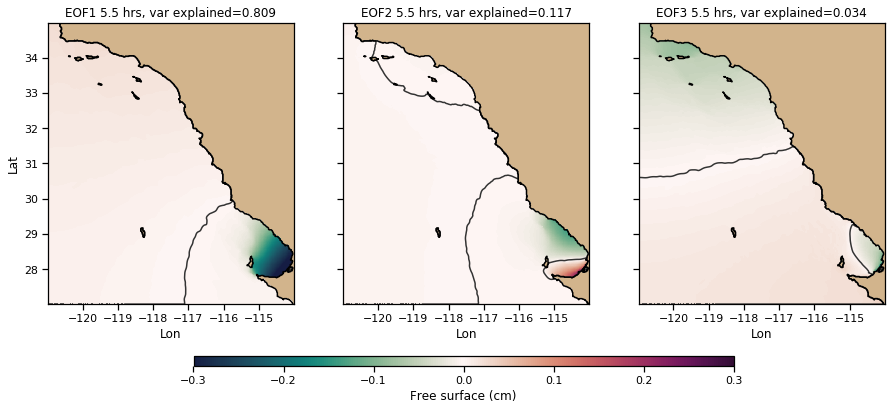

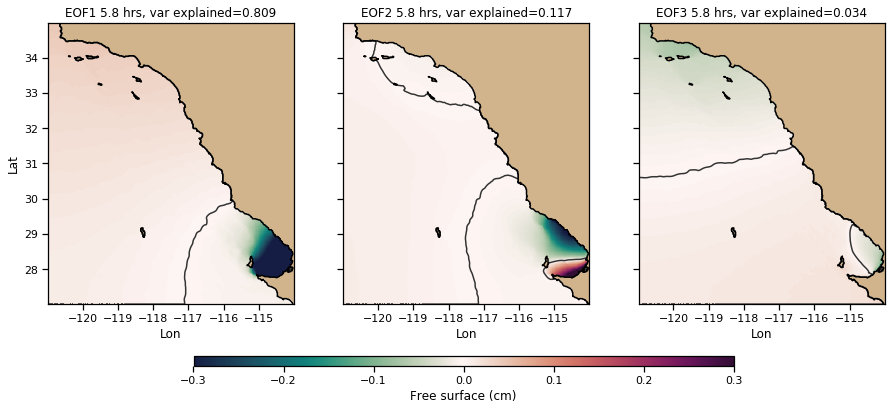

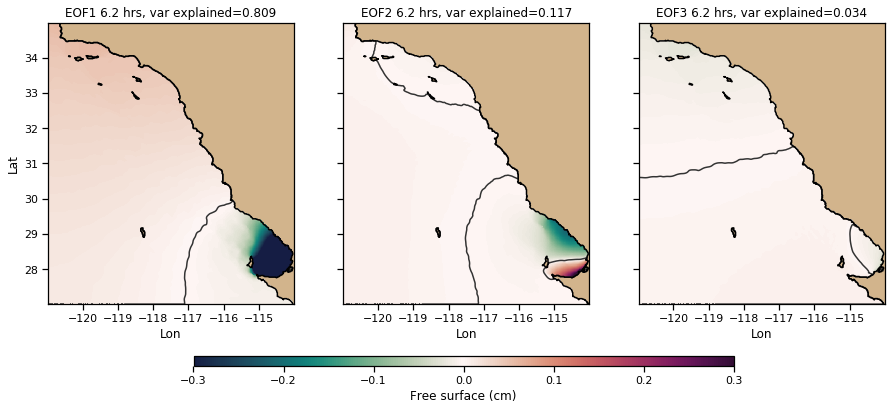

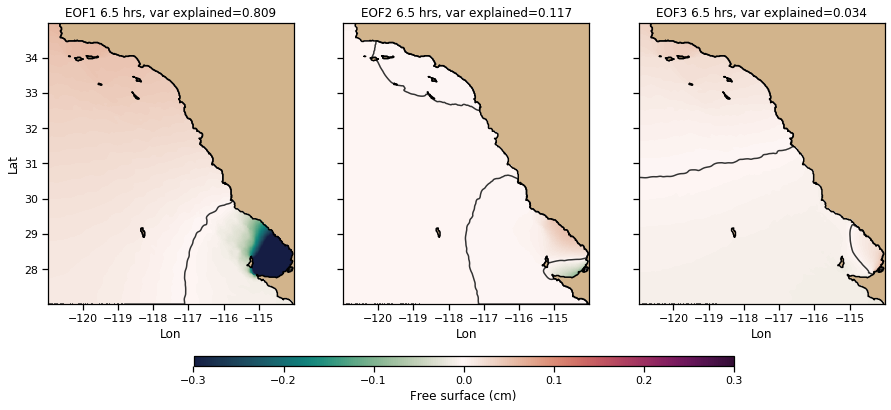

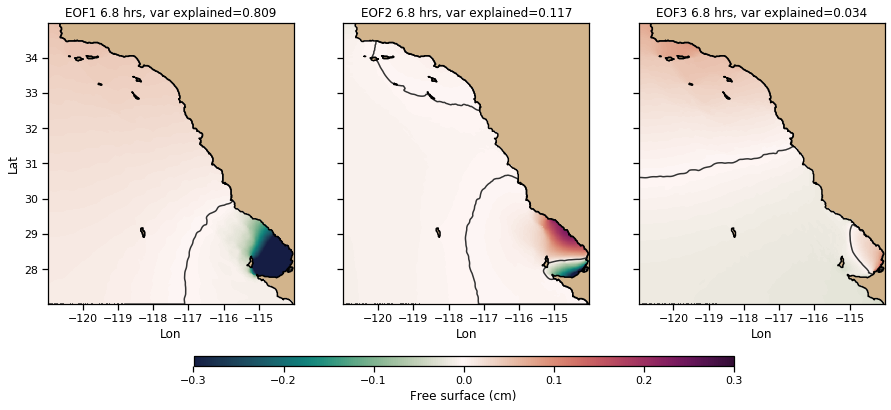

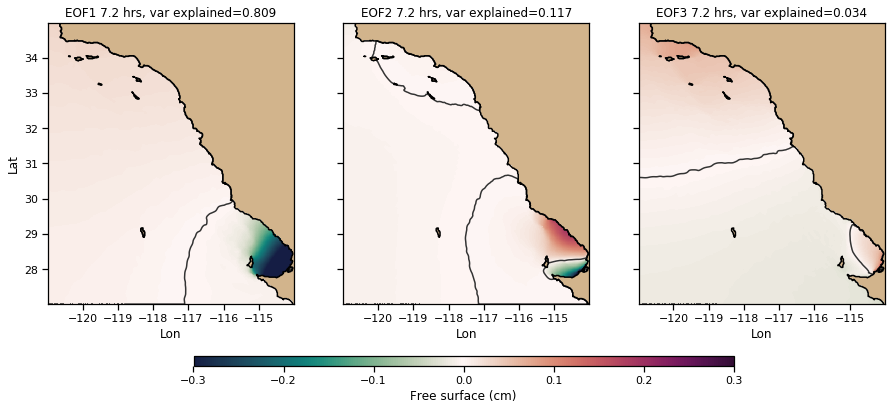

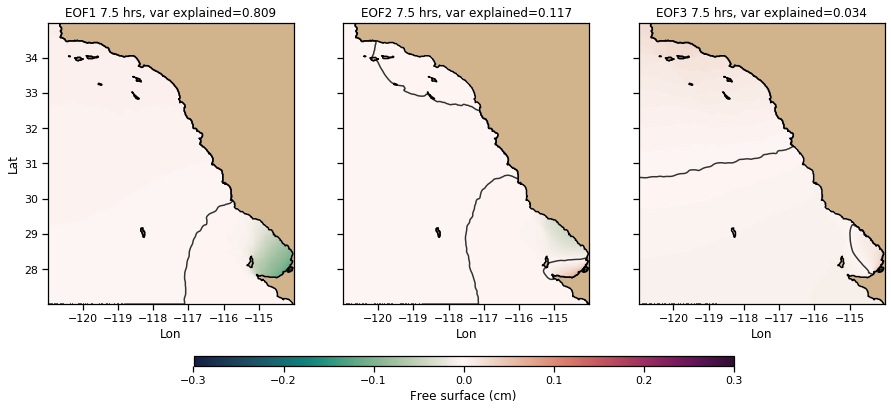

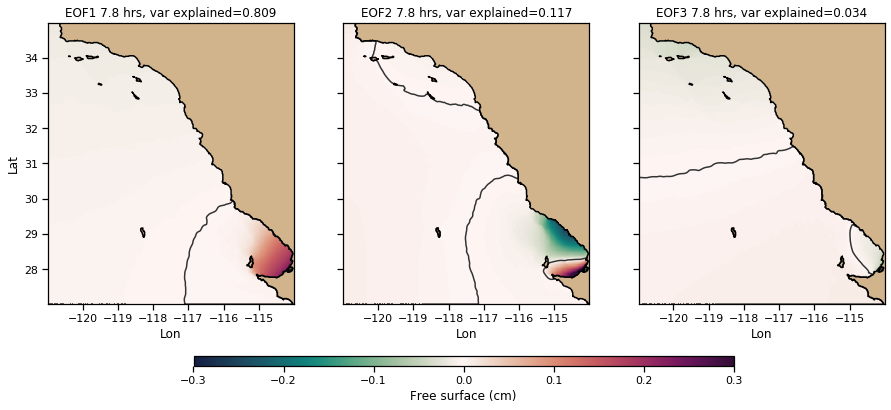

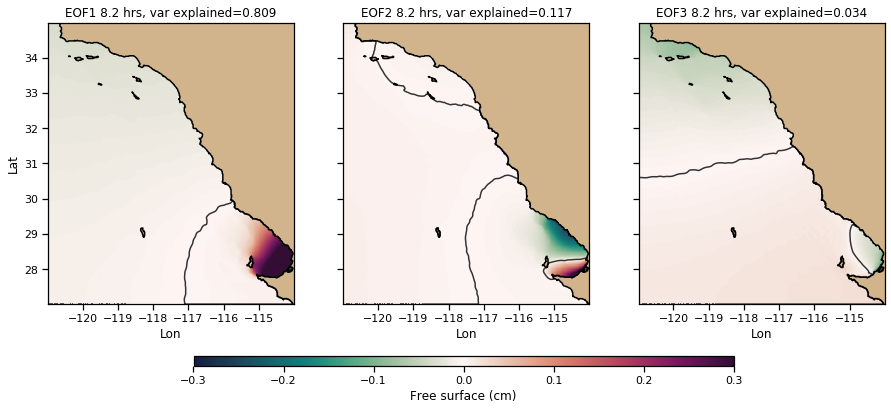

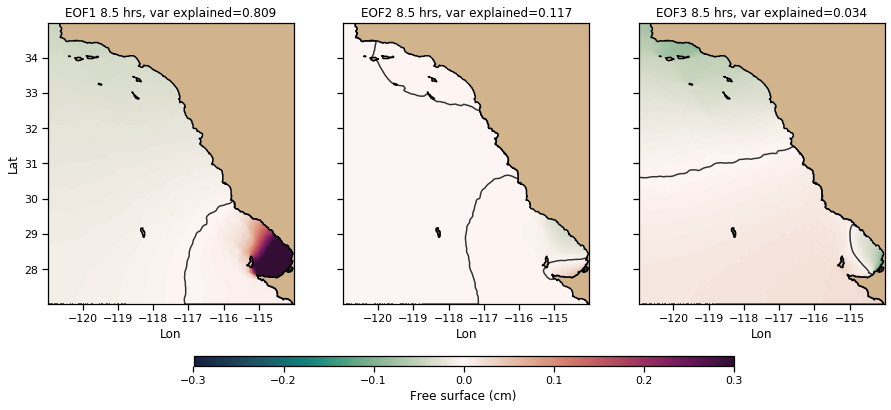

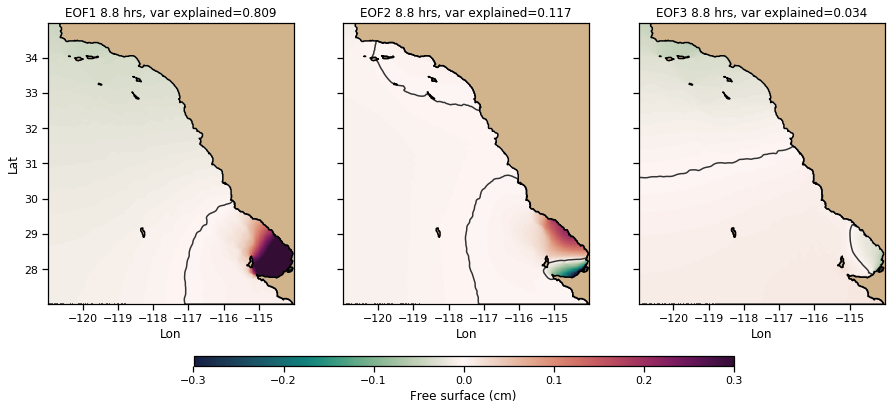

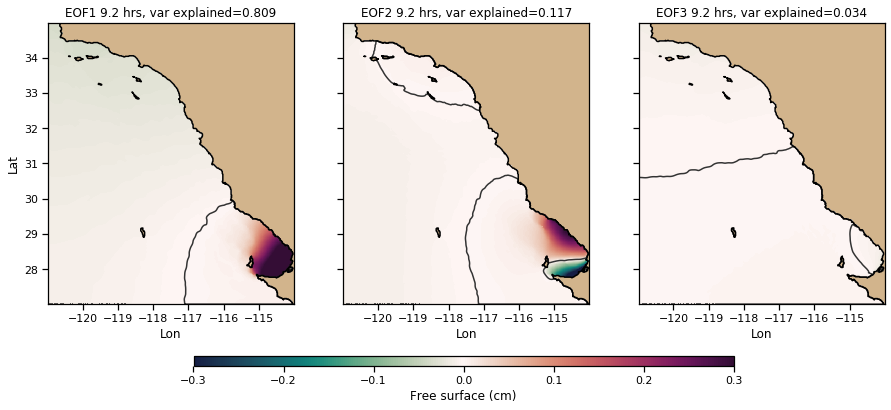

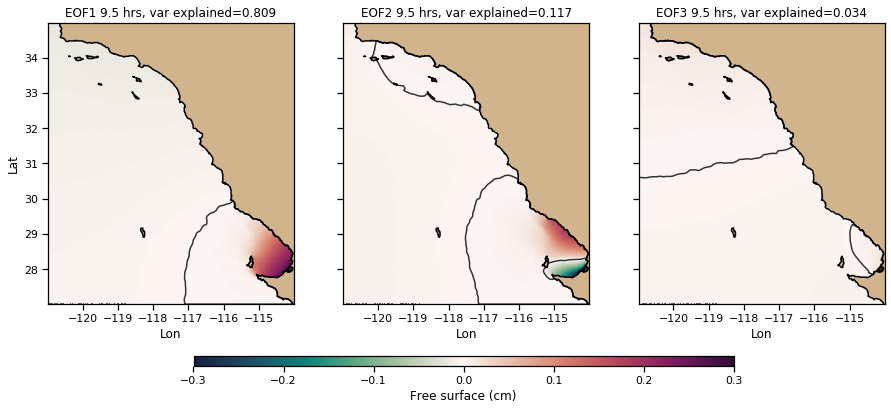

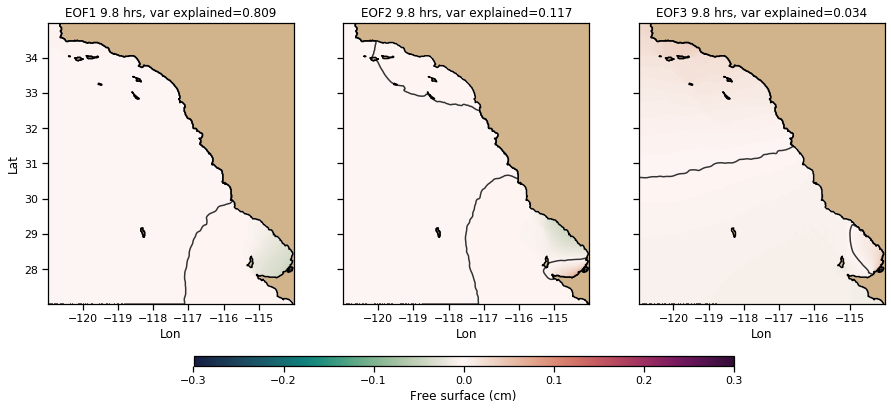

In [23]:
recon1 = solver.reconstructedField([1])
recon2 = solver.reconstructedField([2])
recon3 = solver.reconstructedField([3])
nt=70
times=range(20,60,2)

sns.set_context('notebook')
for tt in times:
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,7), sharey=True)
    for ax in (ax1,ax2,ax3):
        ax.set_aspect(1)
        ax.set_xlabel('Lon') 
        ax.set_facecolor('tan')
    
    ax1.set_ylabel('Lat')

    animate(tt,ax1,ax2,ax3,recon1,recon2,recon3,anim=False)


#### Animation reconstructed field using only mode 1, only mode 2 and only mode 3

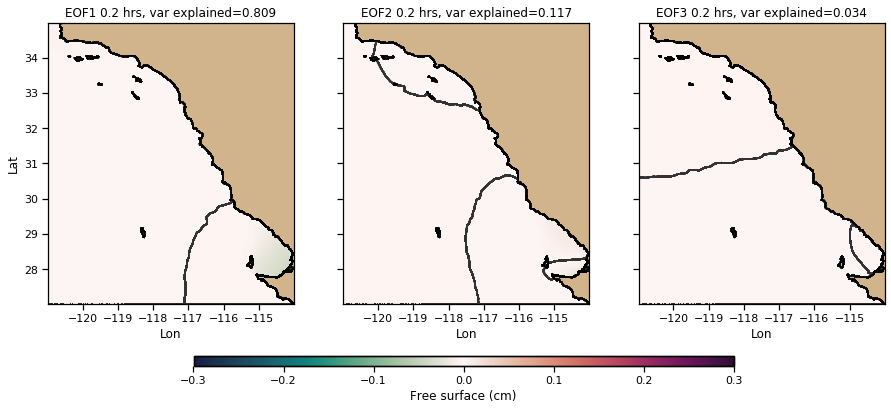

In [40]:
sns.set_context('notebook')
nt=70
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,7), sharey=True)
for ax in (ax1,ax2,ax3):
    ax.set_aspect(1)
    ax.set_xlabel('Lon') 
    ax.set_facecolor('tan')
    
ax1.set_ylabel('Lat')

anim = animation.FuncAnimation(fig, animate, blit=False,fargs=(ax1,ax2,ax3,recon1,recon2,recon3),
                               frames=nt, repeat=False)
#anim.save('modes.mp4', writer=writer)